# 고양이 수염 스티커 만들기

이번 시간에는 이미지 내 사람의 얼굴을 인식하는 모델을 이용하여 나의 얼굴을 모델에게 인식시키고, 인식한 얼굴의 정확한 위치에 고양이 수염 스티커를 합성시키는 코드를 작성해 보려 한다. 그리고 제작된 모델을 바탕삼아 여러가지 이미지를 모델에 인식시켜보는 시험을 진행하려 한다. 시작해보자. 

### 아래와 같은 과정으로 진행

1. 기본 라이브러리 import 및 사진 준비
2. 사진 속 내 얼굴을 찾고 이목구비 인식하기
3. 인식한 이목구비를 기준으로 스티커 위치를 적용하기
4. 결과 확인

## 1-1. 기본 라이브러리 import 및 사진 준비

### 라이브러리 Import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


### 준비한 이미지 읽기

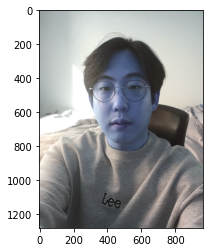

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/my_face.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

### BGR => RGB 보정처리

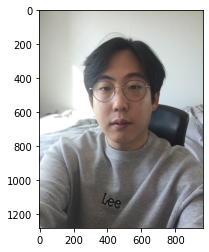

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR을 RGB값으로 변환
plt.imshow(img_rgb)
plt.show()

## 1-2. 사진 속 내 얼굴 찾고 이목구비 인식하기

### HOG Detector를 이용하여 사진 속 내 얼굴 찾기

In [4]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


### 찾은 얼굴 화면 출력

rectangles[[(290, 376) (675, 761)]]


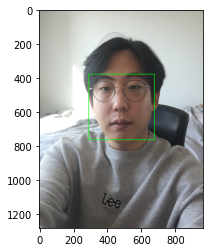

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 인식한 얼굴 내에서 정확한 이목구비 위치 찾기

In [7]:
# 이목구비 인식 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


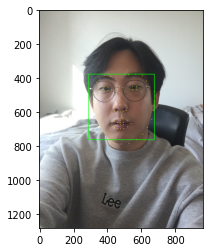

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 1-3. 스티커와 원본 사진 합성

### 인식한 이목구비 위치에서 코의 중심점 찾기

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코 끝의 인덱스 : 33, 코 끝의 위치: (473, 554)
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(473, 554)
(x,y) : (473,554)
(w,h) : (386,386)


### 스티커 이미지 불러오기 및 resizing

(386, 386, 3)


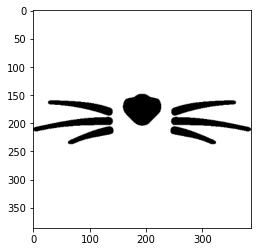

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'

img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 resizing

print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

### 스티커 이미지를 적용하기 위한 좌표 조정

In [12]:
refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하므로
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (280,361)


### np.where 메서드를 이용하여 스티커의 색과 배경을 조절

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

print("슝~")

슝~


### 테스트

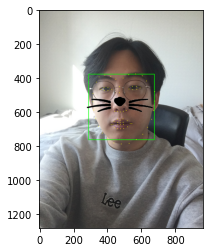

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 얼굴, 이목구비 인식 프레임 제거 후 최종 결과 확인

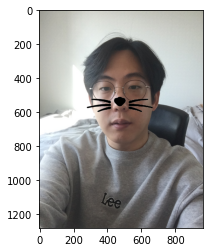

In [15]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 1-4. 중간 후기

여기까지 진행하면서 다른 과정은 별다른 어려움이 없었지만 딱 한가지 과정에서 정말 애를 많이 먹었다. 
고양이 수염 스티커를 다운로드 받고 원본 사진에 합성하는 과정에서 배경색이 흰색으로 계속 등장했었고 흰색 배경을 없애기 위해 엄청 헤맸다. 
그 과정을 정리해보자면 이렇다. 

1. 고양이 수염 이미지를 png로 다운받음
2. 다운받은 이미지 파일을 열어 배경을 확인하였으나 체크무늬 표시는 보이지 않고 흰색으로 나옴
3. 표시 설정상의 문제일 수 있을거라 생각하고 원본 이미지와 합성 시도하여 코드 내에서 배경색 체크
4. 흰색 배경때문에 원본 이미지를 가리는 현상 발생

이런 일이 발생할 때마다 일일이 새로운 방법으로 이미지를 다시 받아 코드를 실행하며 대조하며 실험을 해야했고 결과는 모두 실패였다. 그래서 시도했던 다른 방법으로는 png로 저장해도 흰색 배경이 있을 것이란 가정 하에 여러가지 툴로 배경을 지우는 시도를 했다.(그림판, pdf, 포토샵, 무료 웹 툴 등) 결과는 모두 실패였고 수많은 삽질 끝에 코드를 좀 더 들여보다가 np.where 메서드의 검색을 통해 방법을 찾았다. 

이 과정을 통해 큰 교훈을 얻었다. 

'모든 코드를 하나하나 이해하려 노력하고 살펴보자'

## 2. 다른 이미지로 모델 test 

모델 제작 과정에서 수염 색을 못바꾼 삽질로 인해 꽤 고통을 겪었기에 일반 사람 이미지를 합성하고 그 결과를 살펴보기보다 조금 더 재밌는 이미지들을 합성시키고 그 결과를 살피고 싶었다. 그래서 어떤 이미지를 사용할지, 어떤 과정으로 테스트를 거칠지 고민해 보았고 아래의 과정으로 진행하기로 결정하였다. 

- 사람 이미지 합성부터 캐릭터 이미지까지 단계적 대조를 통해 모델의 얼굴 인식 한계가 어디까지인지 테스트를 시도한다. 

여기서부턴 데이터 준비과정부터 결과 출력까지 과정이 위와 동일하게 반복되기에 따로 과정에 대한 서술 없이 결과만 관찰한다.

## 3-1. Obi-wan Kenobi 얼굴 인식 및 스티커 합성

좋아하는 스타워즈의 캐릭터로 합성을 시도하였다, 배우는 이완 맥그리거.

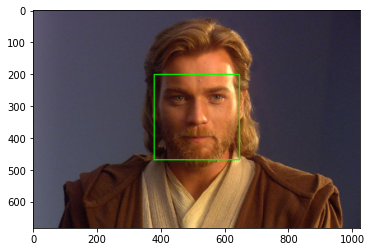

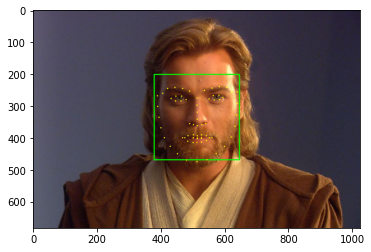

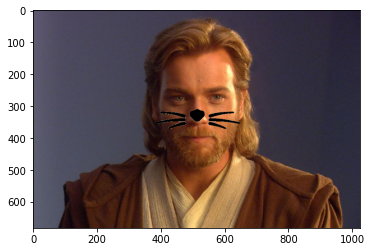

In [16]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_obiwan.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 3-2 Obi-wan kenobi - 결론 

실제 사람을 인식하고 스티커를 합성하는 과정에서 문제 없이 매끄럽게 진행되었다. 

## 4-1. SUA 얼굴인식 및 스티커 합성

이번에 합성을 시도할 이미지는 실제 사람이 아닌 가상의 캐릭터이고 '수아'라는 이름의 Unity 기반 Virtual Influencer이다. 모델이 실제 사람의 이미지가 아닌 가상인간의 이미지도 인식을 할지 궁금해서 시도하였다. 

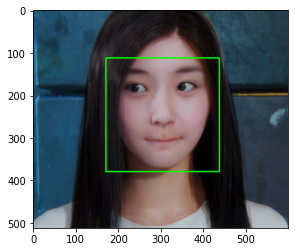

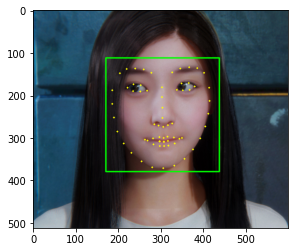

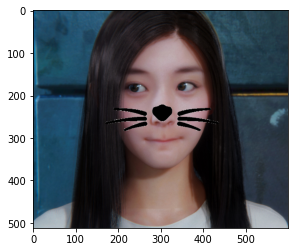

In [17]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_sua.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 4-2. SUA - 결론

아주 잘 인식한다. 모델이 가상인간을 인식하는 것도 흥미롭지만 가상인간의 완성도도 무척 놀랍다. 

## 5-1. YUA 얼굴인식 및 스티커 합성

마찬가지로 실제 사람이 아닌 '한유아'라는 이름의 가상인간이다. 한유아는 AI기반(!) Virtual Artist이다. 인식모델이 사람의 얼굴이 아닌 다른 모델에서 정교하게 제작된 결과물 인식을 시도하는 셈이다. 

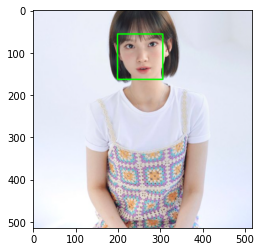

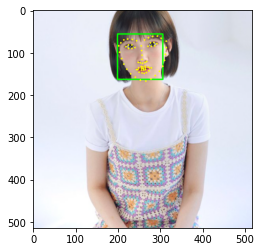

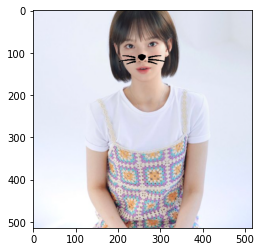

In [18]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_yua.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5-2 YUA - 결론

수염의 각도를 얼굴이 틀어진 각도에 맞게 재조정 할 필요가 있어 보인다. 인식은 아직까지 무리없이 잘 진행되는 모습을 볼 수 있다. 

## 6-1. SEJIN 얼굴인식 및 스티커 합성

이번에는 '세진'이라는 이름의 남자 가상인간이다. 성별을 바꾸어서 한번 시도해보았다. 

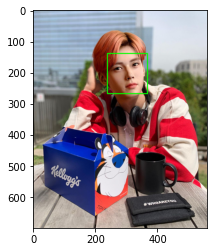

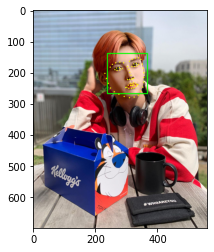

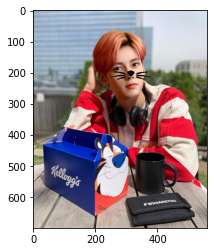

In [19]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_sejin.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 6-2 SEJIN - 결론

마찬가지로 수염의 각도와 비율을 얼굴이 틀어진 각도에 맞게 재조정 할 필요가 있어 보인다. 다만 성별을 바꾼 남자 가상인간의 경우에도 인식이 문제없이 진행되고 있다. 놀라운 점은 3번의 가상인간 인식 시도를 통해 관찰한 결과 모델이 실제 사람의 이미지가 아님에도 불구하고 뛰어난 인식 성능을 보여주고 있다는 점이다.

## 7-1. 게임 일러스트 얼굴인식 및 스티커 합성

난이도를 더욱 올려보았다. 이번에는 모두가 아는 '스타크래프트' 게임의 케리건 - 칼날여왕 이라는 캐릭터로 합성을 시도해 보았다. 게임 내 일러스트 중 하나를 사용하였다. 

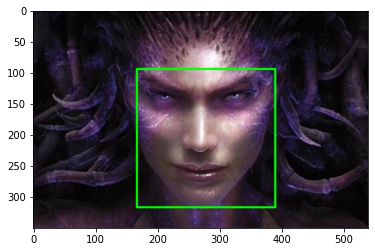

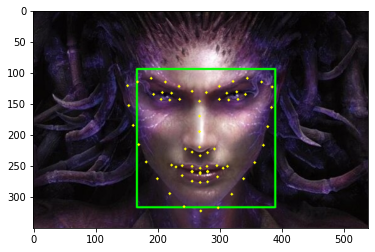

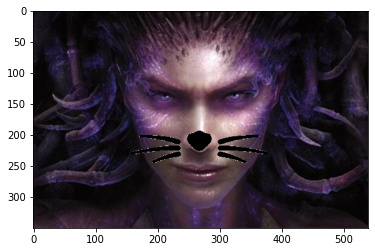

In [20]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_star.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 7-2 게임 일러스트 - 결론

심지어 일러스트의 이목구비도 완벽하게 인식한다! 대체 이 모델의 한계는 어디까지인지 한번 시험해보자.

## 8-1. 심약자 주의!!! 좀비 얼굴인식 및 스티커 합성

이 실험의 결과와 모델의 한계가 어디까지인지 궁금해서 시도해 보지 않을 수 없다.

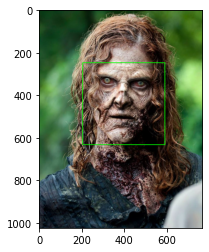

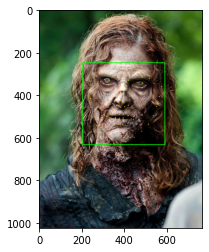

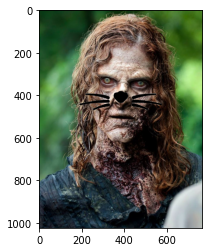

In [21]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_zombie.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 8-2 Zombie - 결론

와우.. 

## 9-1. Avatar 캐릭터 얼굴인식 및 스티커 합성

문득 이목구비의 골격이 다르면 어떻게 될까 궁금해졌다. 좀비의 경우 인간의 시각에서 바라볼땐 여러가지 징그러운 특징적 요소로 인해 보편적인 사람의 형상 이미지와 많이 다르다고 생각되지만 위의 이미지에서도 좀비의 얼굴 골격이 크게 차이나는 부분은 없었다. 따라서 Avatar의 캐릭터처럼 얼굴 골격 자체가 보편적인 사람의 얼굴 골격과 다른 경우 인식률이 어떻게 될지 궁금해서 시도해 보았다. 

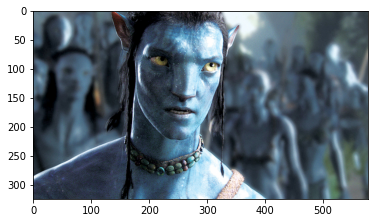

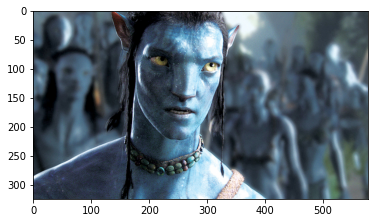

ValueError: operands could not be broadcast together with shapes (386,386,3) (93,386,3) (386,386,3) 

In [22]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_avatar.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 9-2 Avatar - 1차 결론

에러가 발생한다. 다른 이미지로 재시도 해본다. 

## 9-3. (2차) Avatar 캐릭터 얼굴인식 및 스티커 합성

이번엔 여자주인공의 얼굴 이미지로 재시도한다. 

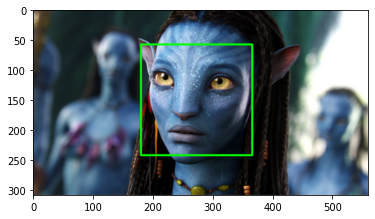

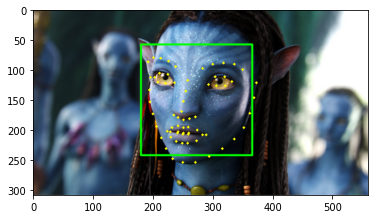

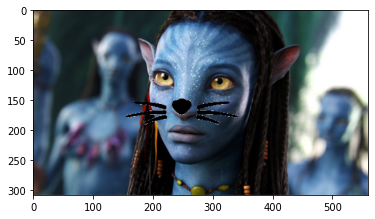

In [23]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_avatar_2.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

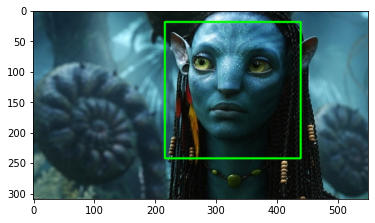

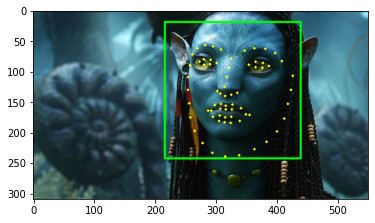

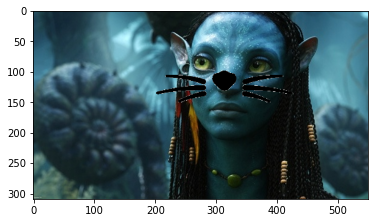

In [24]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/cats_whiskers/test_images/test_avatar_3.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다


# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
    

model_path = os.getenv('HOME')+'/aiffel/cats_whiskers/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코 끝 x 좌표값
    y = landmark[30][1] # 코 끝 y 좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계 박스 너비
    h = dlib_rect.height() # 수염 스티커 resize를 위한 경계 박스 높이
 
    
sticker_path = os.getenv('HOME')+'/aiffel/cats_whiskers/images/cat-whiskers .png'


img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2 # 이미지 배치 좌표의 기본값인 left, top(0,0)이 코의 인덱스에 위치하기 때문에 
refined_y = y - w // 2 # width / 2 값을 빼주어 얼굴 이목구비 frame과 위치를 맞춤


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # 수염의 배경색이 흰색이므로 255px 컬러를 제외하고 출력


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 9-4 Avatar 결론

이 얼굴인식 알고리즘을 만드신 분은 대체 누굴까? 정말 대단하다.

# 10. 최종 후기

이번 Exploration에서는 기술적인 배움도 얻었지만 여러가지 시도를 통해 많은 재미를 느꼈다. 사실 더 많이 시도해 보고 싶었지만 이러다간 끝도 없이 계속 하게 될 것 같아 아쉬움을 머금고 마무리 지으려 한다. 힘들었던 점으로는 중간에 스티커 이미지의 색 변경과 배경처리 문제를 지나치게 헤매는 바람에 정말 고통스러웠으나 그 고통의 값어치만큼 중요한 교훈을 얻었다. 또한 아쉬웠던 점으로 여러가지 이미지로 모델을 시험하면서 수염의 각도가 얼굴의 각도와 일치하지 않는 현상을 관찰하였고 이미지 내 얼굴의 각도에 맞게 수염 스티커의 비율과 각도를 조절하고 싶었으나 마무리하는 시점까지 기술적 문제를 해결할 수 없었다. 항상 이런 수학적 문제에 부딪혔을때 식과 해결책을 제대로 구하지 못해 적용을 어려워 했었기에 수학적 소양의 필요성을 절감하였다. 다만 여러가지 아쉬웠던 점에도 불구하고 재미있는 시도를 통해 즐겁게 문제를 극복하고자 하였으며 중요한 교훈을 얻고 다음 노드로 나아갈 수 있다는 점에 의의를 두며 글을 마친다. 